In [8]:
import pandas as pd
from collections import Counter
import math
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import pandas as pd

## Load the data and create the news_id and full_text columns

In [9]:

# Load fake and real news datasets
pf_fake = pd.read_csv("../data/raw/FakeNewsNet/BuzzFeed_fake_news_content.csv")
pf_real = pd.read_csv("../data/raw/FakeNewsNet/BuzzFeed_real_news_content.csv")

# Concatenate them into a full dataset
df_full = pd.concat([pf_real, pf_fake], ignore_index=True)

# Append news_id from PolitiFactNews.txt
with open('../data/raw/FakeNewsNet/BuzzFeedNews.txt', 'r') as file:
    news_ids = [line.strip() for line in file]

df_full["news_id"] = news_ids

# Load train and test id's
with open('../data/processed/FakeNewsNet/BuzzFeed_trainIds.txt', 'r') as file:
    train_values = [line.strip() for line in file]
with open('../data/processed/FakeNewsNet/BuzzFeed_testIds.txt', 'r') as file:
    test_values = [line.strip() for line in file]

# Create train and test data sets
df_train = df_full[df_full['news_id'].isin(train_values)]
df_test = df_full[df_full['news_id'].isin(test_values)]

df_train["full_text"] = df_train["title"] + " " + df_train["text"]
df_test["full_text"] = df_test["title"] + " " + df_test["text"]

# Create a label column stating whether the news is fake or real based on the news_id column
df_train["label"] = df_train["news_id"].apply(lambda x: "fake" if x.split("_")[1].lower() == "fake" else "real")
df_test["label"] = df_test["news_id"].apply(lambda x: "fake" if x.split("_")[1].lower() == "fake" else "real")


C:\Users\alex\AppData\Local\Temp\ipykernel_22716\2063233880.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alex\AppData\Local\Temp\ipykernel_22716\2063233880.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alex\AppData\Local\Temp\ipykernel_22716\2063233880.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

## Creating a TF-IDF representation.

In [10]:
# Download the stopwords dataset
nltk.download('stopwords', quiet=True)


def tokenize(text, stemmer, stop_words):
    """Tokenize text, stem, and remove stop words."""
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [stemmer.stem(token) for token in tokens if token not in stop_words]

def compute_tfidf_train(df, column_name):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    # Tokenize, stem and compute term frequency for each document
    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Create a list of all unique words in the corpus
    all_unique_words = list(set(word for tf in df['tf'] for word in tf.keys()))

    # Compute the number of documents in which each word appears
    word_document_count = Counter(word for tf in df['tf'] for word in tf.keys())

    # Compute the total number of documents
    total_documents = len(df)

    # Compute inverse document frequency for each word
    idf = {word: math.log(total_documents / count) for word, count in word_document_count.items()}

    # Compute TF-IDF for each word in each document and ensure that all words in the corpus are represented
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * idf[word] for word in all_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf'], all_unique_words, idf


# We create a separate function for the test data because we need to use the IDF from the training data
def compute_tfidf_test(df, column_name, train_unique_words, train_idf):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))

    df['tf'] = df[column_name].apply(lambda x: Counter(tokenize(x, stemmer, stop_words)))

    # Compute TF-IDF for each word in each document using the vocabulary and IDF from training data
    def calculate_tfidf(tf):
        return {word: tf.get(word, 0)/sum(tf.values()) * train_idf[word] for word in train_unique_words}

    df['tfidf'] = df['tf'].apply(calculate_tfidf)

    return df['tfidf']

# For the training data
df_train['tfidf'], train_unique_words, train_idf = compute_tfidf_train(df_train, 'full_text')

# For the test data
df_test['tfidf'] = compute_tfidf_test(df_test, 'full_text', train_unique_words, train_idf)

df_train.to_csv("../data/processed/FakeNewsNet/train.csv", index=False)
df_test.to_csv("../data/processed/FakeNewsNet/test.csv", index=False)


C:\Users\alex\AppData\Local\Temp\ipykernel_22716\884586417.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alex\AppData\Local\Temp\ipykernel_22716\884586417.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\alex\AppData\Local\Temp\ipykernel_22716\884586417.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

## Word clouds for fake and real news

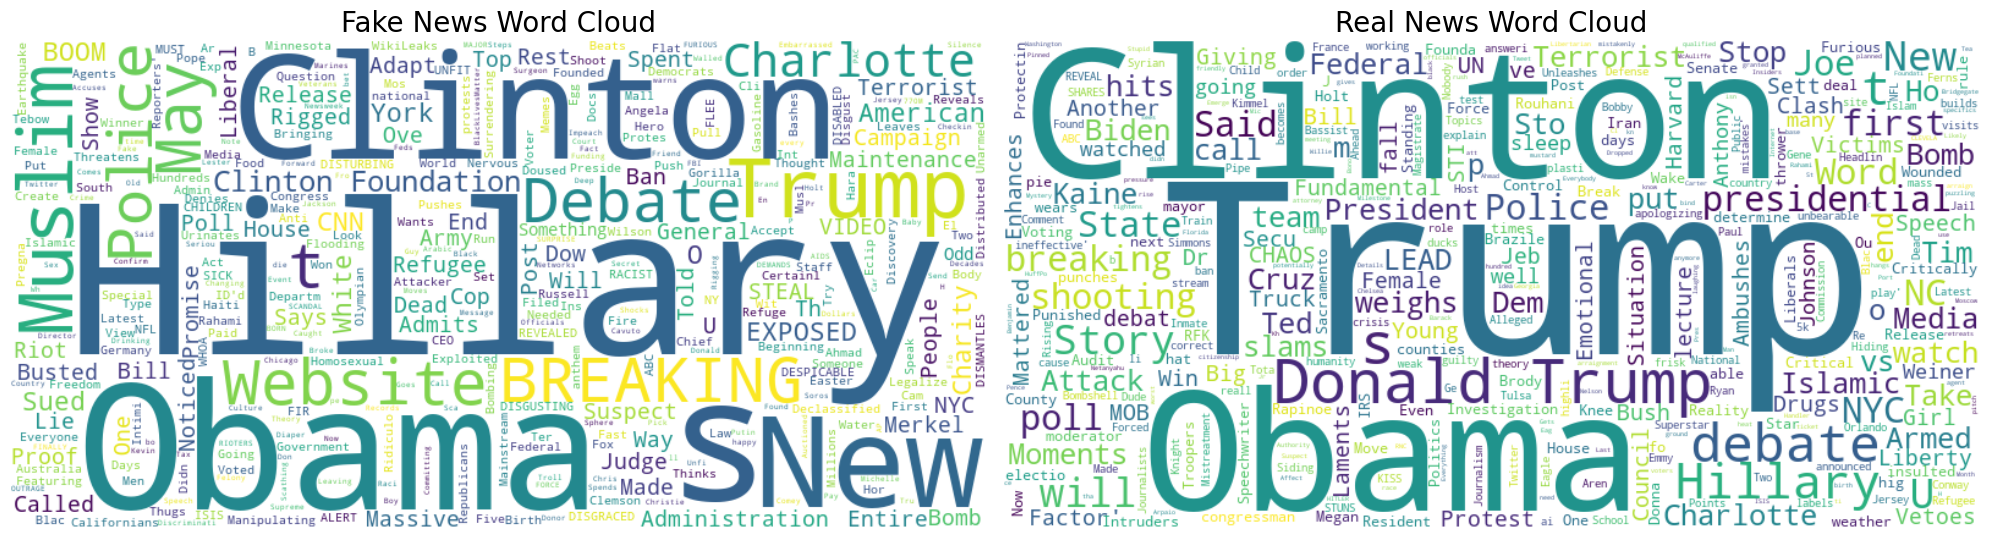

In [11]:
# Create word cloud for the fake news
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pf_fake["full_text"] = pf_fake["title"] + " " + pf_fake["text"]

pf_real["full_text"] = pf_real["title"] + " " + pf_real["text"]

# Create a word cloud for the fake news
wordcloud_fake = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_fake.generate(pf_fake["full_text"].to_string())
wordcloud_fake.to_image()

# Create a word cloud for the real news
wordcloud_real = WordCloud(background_color="white",
                           max_words=5000,
                           contour_width=3,
                           contour_color='steelblue',
                           width=800,  
                           height=400  
                          )
wordcloud_real.generate(pf_real["full_text"].to_string())
wordcloud_real.to_image()

# Set up the figure and axes
fig, axarr = plt.subplots(1, 2, figsize=(20, 10))  # 1x2 grid of plots, adjust the figure size as needed

# Display the fake news word cloud on the left subplot
axarr[0].imshow(wordcloud_fake, interpolation='bilinear')
axarr[0].axis('off')
axarr[0].set_title("Fake News Word Cloud", fontsize=20)

# Display the real news word cloud on the right subplot
axarr[1].imshow(wordcloud_real, interpolation='bilinear')  # Make sure you're showing wordcloud_real here
axarr[1].axis('off')
axarr[1].set_title("Real News Word Cloud", fontsize=20)

# Adjust the spacing between the plots if necessary
plt.tight_layout()

plt.show()





In [12]:
print(pf_fake.shape)
print(pf_real.shape)
#pf_fake

(91, 13)
(91, 13)


In [13]:
#pf_fake

## PCA on the training data

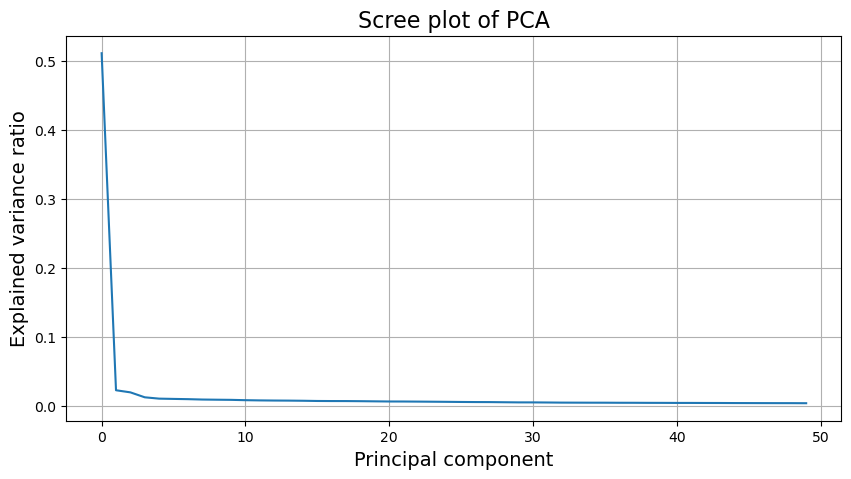

C:\Users\alex\AppData\Local\Temp\ipykernel_22716\1510258318.py:30: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



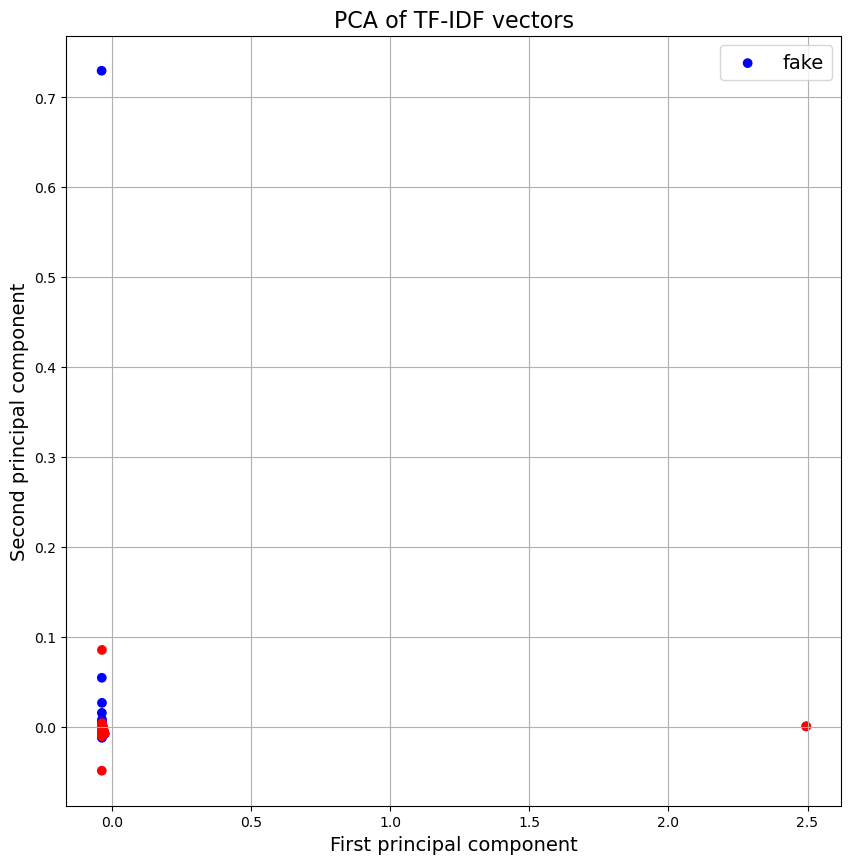

In [14]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot

# Convert the dictionaries in the "tfidf" column into a matrix
dict_vectorizer = DictVectorizer(sparse=False)
tfidf_matrix_train = dict_vectorizer.fit_transform(df_train['tfidf'])
tfidf_matrix_test = dict_vectorizer.fit_transform(df_test['tfidf'])

# Compute PCA of the TF-IDF vectors
pca = PCA(n_components=50)
pca.fit(tfidf_matrix_train)

# Transform the TF-IDF matrix using the PCA model
tfidf_pca = pca.transform(tfidf_matrix_train)

plt.figure(figsize=(10, 5))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal component', fontsize=14)
plt.ylabel('Explained variance ratio', fontsize=14)
plt.title('Scree plot of PCA', fontsize=16)
plt.grid(True)
plt.show()

# Create a scatter plot of the two first principal components
plt.figure(figsize=(10, 10))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], c=df_train['label'].map({'fake': 'red', 'real': 'blue'}), cmap='coolwarm')
plt.xlabel('First principal component', fontsize=14)
plt.ylabel('Second principal component', fontsize=14)
plt.title('PCA of TF-IDF vectors', fontsize=16)
plt.grid(True)
plt.legend(['fake', 'real'], fontsize=14)
plt.show()

In [15]:
tfidf_matrix_train.shape

(146, 6303)

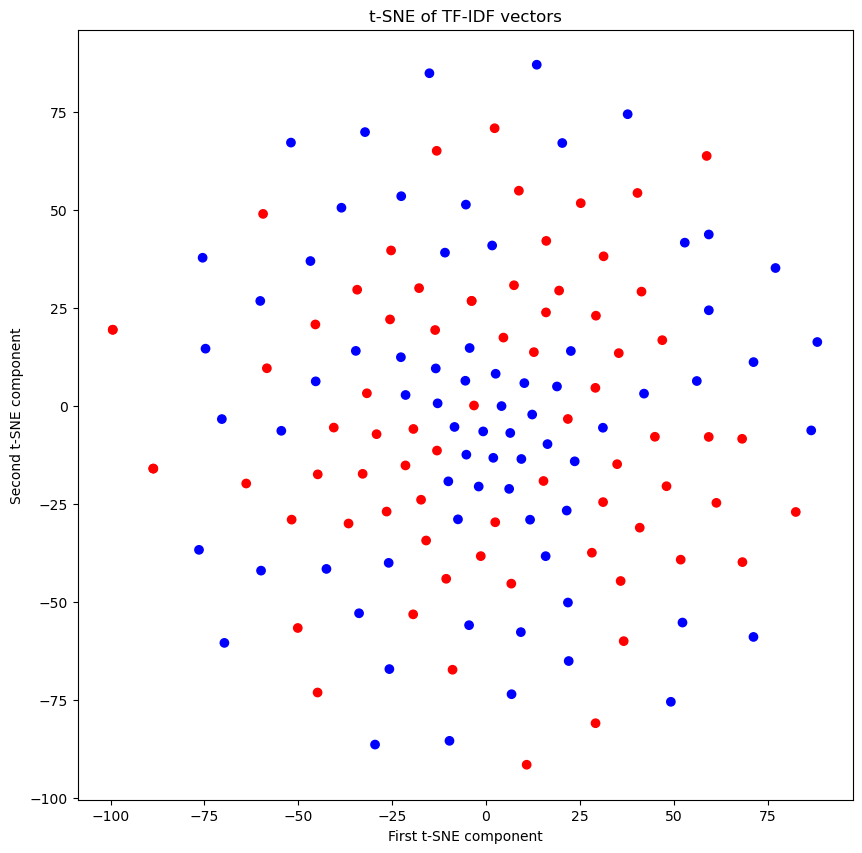

In [16]:
#Meget stor forskel på TSNE og PCA

# Create a t-SNE scatter plot of the trainind data
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Compute t-SNE of the TF-IDF vectors
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=1000)
tsne.fit(tfidf_matrix_train)

# Transform the TF-IDF matrix using the t-SNE model
tfidf_tsne = tsne.fit_transform(tfidf_matrix_train)

# Create a scatter plot of the two first t-SNE components
plt.figure(figsize=(10, 10))
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], c=df_train['label'].map({'fake': 'red', 'real': 'blue'}))
plt.xlabel('First t-SNE component')
plt.ylabel('Second t-SNE component')
plt.title('t-SNE of TF-IDF vectors')
plt.show()


In [17]:
# # Create a UMAP scatter plot of the training data
# import umap.umap_ as umap
# import matplotlib.pyplot as plt

# # Compute UMAP of the TF-IDF vectors
# umap = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1)
# umap.fit(tfidf_matrix)

# # Transform the TF-IDF matrix using the UMAP model
# tfidf_umap = umap.fit_transform(tfidf_matrix)

# # Create a scatter plot of the two first UMAP components
# plt.figure(figsize=(10, 10))
# plt.scatter(tfidf_umap[:, 0], tfidf_umap[:, 1], c=df_train['label'].map({'fake': 'red', 'real': 'blue'}))
# plt.xlabel('First UMAP component')
# plt.ylabel('Second UMAP component')
# plt.title('UMAP of TF-IDF vectors')
# plt.show()


In [18]:
# Function to calculate the cosine similarity between two vectors

def cosine_similarity(vector1, vector2):
    """Calculate the cosine similarity between two vectors."""
    dot_product = sum(p*q for p, q in zip(vector1, vector2))
    magnitude = math.sqrt(sum([val**2 for val in vector1])) * math.sqrt(sum([val**2 for val in vector2]))
    if not magnitude:
        return 0
    return dot_product/magnitude



In [19]:
from scipy.spatial import distance_matrix
tfidf_matrix_train


dist_matrix = distance_matrix(tfidf_matrix_train, tfidf_matrix_train)
dist_matrix = dist_matrix.flatten()
dist_matrix = dist_matrix[dist_matrix != 0]
print(dist_matrix.min(), dist_matrix.max(), dist_matrix.mean(), dist_matrix.std())

0.13229456527275732 2.635644701465563 0.4550989642420861 0.36568856857468235


In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(tfidf_matrix_train)
tfidf_matrix_train_pca = pca.transform(tfidf_matrix_train)
tfidf_matrix_train_pca.shape

(146, 100)

In [20]:
#Gives Precisely a 50/50 representation:
from sklearn.cluster import DBSCAN
import numpy as np
tf_idf_matrix_complete = np.vstack((tfidf_matrix_train, tfidf_matrix_test))
tf_idf_matrix_complete.shape

#There cosine similarity needs to be 0.9 or higher to be considered a cluster. 

#The distance measure (used for eps) is 1 - cosine similarity. Thats why it works inversely. The lower the value the more similar 
#they have to be to be considered a cluster. 

dbscan_cosine = DBSCAN(eps=0.9, min_samples =5, metric="cosine")
dbscan_cosine.fit(tfidf_matrix_train)
print(len(dbscan_cosine.labels_))
dbscan_cosine.labels_

146


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,
        0, -1, -1,  0,  0, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0, -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,
       -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0, -1,  0,  0, -1, -1,  0,  0,  0, -1,  0,  0,
        0, -1, -1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0], dtype=int64)

In [21]:
clusters = np.unique(dbscan_cosine.labels_)
for i in clusters: 
    print(i)

-1
0


In [22]:
#Get index of all -1 values in the labels array
dbscan_cosine_Class_1 = [i for i, x in enumerate(dbscan_cosine.labels_) if x == 1]
dbscan_cosine_Class_0 = [i for i, x in enumerate(dbscan_cosine.labels_) if x == 0]
dbscan_cosine_Class_2 = [i for i, x in enumerate(dbscan_cosine.labels_) if x == 2]
dbscan_cosine_Class_11 = [i for i, x in enumerate(dbscan_cosine.labels_) if x == -1]
print(len(dbscan_cosine_Class_1))
dbscan_cosine_Class_1

0


[]

In [23]:
#df_train["label"]
df_train['tfidf']
tfidf_matrix_train.shape

(146, 6303)

In [24]:
dbscan_cosine_Class_1_labels = np.array(list(df_train["label"]))[dbscan_cosine_Class_1]
dbscan_cosine_Class_1_labels
print('Real:')
print(np.count_nonzero(dbscan_cosine_Class_1_labels == "real"))
print('Fake:')
print(np.count_nonzero(dbscan_cosine_Class_1_labels == "fake"))

Real:
0
Fake:
0


In [25]:
dbscan_cosine_Class_0_labels = np.array(list(df_train["label"]))[dbscan_cosine_Class_0]
dbscan_cosine_Class_0_labels
print('Real:')
print(np.count_nonzero(dbscan_cosine_Class_0_labels == "real"))
print('Fake:')
print(np.count_nonzero(dbscan_cosine_Class_0_labels == "fake"))

Real:
57
Fake:
57


In [26]:
dbscan_cosine_Class_2_labels = np.array(list(df_train["label"]))[dbscan_cosine_Class_2]
dbscan_cosine_Class_2_labels
print('Real:')
print(np.count_nonzero(dbscan_cosine_Class_2_labels == "real"))
print('Fake:')
print(np.count_nonzero(dbscan_cosine_Class_2_labels == "fake"))

Real:
0
Fake:
0


In [27]:
dbscan_cosine_Class_11_labels = np.array(list(df_train["label"]))[dbscan_cosine_Class_11]
dbscan_cosine_Class_11_labels
print('Real:')
print(np.count_nonzero(dbscan_cosine_Class_11_labels == "real"))
print('Fake:')
print(np.count_nonzero(dbscan_cosine_Class_11_labels == "fake"))

Real:
16
Fake:
16


***DBSCAN_euclidean***

In [28]:
dbscan_euclidean = DBSCAN(eps=0.3, min_samples =3, metric="euclidean")
dbscan_euclidean.fit(tf_idf_matrix_complete)
print(len(dbscan_euclidean.labels_))
dbscan_euclidean.labels_

182


array([ 0,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0, -1, -1,  0, -1,  0,
        0, -1, -1,  0,  0, -1, -1,  0,  0, -1, -1, -1,  0,  0, -1,  0, -1,
       -1,  0, -1,  0,  0,  0, -1,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,
       -1,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  0, -1,  0, -1, -1,
       -1,  0, -1,  0, -1,  0,  0,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0,
        0,  0, -1, -1,  0, -1, -1,  0,  0, -1,  0,  0,  0,  0, -1, -1,  0,
       -1,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0, -1,  0, -1,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        0, -1, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0, -1,  0,  0, -1,  0,
        0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0], dtype=int64)

In [29]:
print(dbscan_euclidean.labels_)
print(len(dbscan_euclidean.labels_))

test_clusters = dbscan_euclidean.labels_[-36:]
print(test_clusters)
print(len(test_clusters))
train_clusters = dbscan_euclidean.labels_[:-36]
print(train_clusters)
print(len(train_clusters))
dbscan_euclidean = DBSCAN(eps=0.3, min_samples =3, metric="euclidean")
dbscan_euclidean.fit(tfidf_matrix_train)
print(dbscan_euclidean.labels_)

dbscan_euclidean = DBSCAN(eps=0.3, min_samples =3, metric="euclidean")
dbscan_euclidean.fit(tf_idf_matrix_complete)

[ 0  0  0  0  0 -1  0  0  0 -1 -1  0 -1 -1  0 -1  0  0 -1 -1  0  0 -1 -1
  0  0 -1 -1 -1  0  0 -1  0 -1 -1  0 -1  0  0  0 -1  0  0 -1 -1  0 -1  0
  0  0  0 -1  0  0  0 -1 -1 -1 -1  0  0  0  0  0 -1  0 -1 -1 -1  0 -1  0
 -1  0  0  0 -1 -1  0  0 -1  0  0  0  0  0  0 -1 -1  0 -1 -1  0  0 -1  0
  0  0  0 -1 -1  0 -1  0  0  0  0  0 -1 -1  0  0  0 -1  0 -1  0  0  0  0
  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0  0 -1  0 -1 -1 -1  0  0  0 -1
  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0 -1  0  0 -1  0  0
 -1  0  0 -1  0  0  0  0  0 -1  0  0  0  0]
182
[ 0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0 -1  0  0 -1  0  0 -1  0
  0 -1  0  0  0  0  0 -1  0  0  0  0]
36
[ 0  0  0  0  0 -1  0  0  0 -1 -1  0 -1 -1  0 -1  0  0 -1 -1  0  0 -1 -1
  0  0 -1 -1 -1  0  0 -1  0 -1 -1  0 -1  0  0  0 -1  0  0 -1 -1  0 -1  0
  0  0  0 -1  0  0  0 -1 -1 -1 -1  0  0  0  0  0 -1  0 -1 -1 -1  0 -1  0
 -1  0  0  0 -1 -1  0  0 -1  0  0  0  0  0  0 -1 -1  0 -1 -1  0  0 -1  0
  0  0  0 -1 -1  0 -1  0  0  0  0  

DBSCAN(eps=0.3, min_samples=3)

In [30]:
dbscan_euclidean_Class_1 = [i for i, x in enumerate(dbscan_euclidean.labels_) if x == 1]
dbscan_euclidean_Class_0 = [i for i, x in enumerate(dbscan_euclidean.labels_) if x == 0]
dbscan_euclidean_Class_2 = [i for i, x in enumerate(dbscan_euclidean.labels_) if x == 2]
dbscan_euclidean_Class_11 = [i for i, x in enumerate(dbscan_euclidean.labels_) if x == -1]
print(len(dbscan_euclidean_Class_1))
dbscan_euclidean_Class_1

0


[]

In [31]:
#df_train["label"]
#df_train['tfidf']
#tfidf_matrix_train.shape
all_labels = list(df_train['label']) + (list(df_test['label']))
len(all_labels)

182

In [32]:
dbscan_euclidean_Class_1_labels = np.array(all_labels)[dbscan_euclidean_Class_1]
dbscan_euclidean_Class_1_labels
print('Real:')
print(np.count_nonzero(dbscan_euclidean_Class_1_labels == "real"))
print('Fake:')
print(np.count_nonzero(dbscan_euclidean_Class_1_labels == "fake"))

Real:
0
Fake:
0


In [33]:
dbscan_euclidean_Class_0_labels = np.array(all_labels)[dbscan_euclidean_Class_0]
dbscan_euclidean_Class_0_labels
print('Real:')
print(np.count_nonzero(dbscan_euclidean_Class_0_labels == "real"))
print('Fake:')
print(np.count_nonzero(dbscan_euclidean_Class_0_labels == "fake"))
dbscan_euclidean_Class_0

Real:
56
Fake:
65


[0,
 1,
 2,
 3,
 4,
 6,
 7,
 8,
 11,
 14,
 16,
 17,
 20,
 21,
 24,
 25,
 29,
 30,
 32,
 35,
 37,
 38,
 39,
 41,
 42,
 45,
 47,
 48,
 49,
 50,
 52,
 53,
 54,
 59,
 60,
 61,
 62,
 63,
 65,
 69,
 71,
 73,
 74,
 75,
 78,
 79,
 81,
 82,
 83,
 84,
 85,
 86,
 89,
 92,
 93,
 95,
 96,
 97,
 98,
 101,
 103,
 104,
 105,
 106,
 107,
 110,
 111,
 112,
 114,
 116,
 117,
 118,
 119,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 131,
 132,
 133,
 134,
 136,
 140,
 141,
 142,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 161,
 163,
 164,
 166,
 167,
 169,
 170,
 172,
 173,
 174,
 175,
 176,
 178,
 179,
 180,
 181]

In [34]:
dbscan_euclidean_Class_2_labels = np.array(all_labels)[dbscan_euclidean_Class_2]
dbscan_euclidean_Class_2_labels
print('Real:')
print(np.count_nonzero(dbscan_euclidean_Class_2_labels == "real"))
print('Fake:')
print(np.count_nonzero(dbscan_euclidean_Class_2_labels == "fake"))

Real:
0
Fake:
0


In [35]:
dbscan_euclidean_Class_11_labels = np.array(all_labels)[dbscan_euclidean_Class_11]
dbscan_euclidean_Class_11_labels
print('Real:')
print(np.count_nonzero(dbscan_euclidean_Class_11_labels == "real"))
print('Fake:')
print(np.count_nonzero(dbscan_euclidean_Class_11_labels == "fake"))

Real:
35
Fake:
26


In [36]:
from sklearn.ensemble import RandomForestClassifier
tfidf_matrix_train.shape
y = dbscan_euclidean_Class_11_labels
X = tfidf_matrix_train[dbscan_euclidean_Class_11]
clf = RandomForestClassifier(n_estimators=100, random_state=42)
print(X.shape)
print(y.shape)
clf.fit(X, y)

IndexError: index 151 is out of bounds for axis 0 with size 146

In [37]:
print(tfidf_matrix_train.shape)
print(tfidf_matrix_test.shape)

(146, 6303)
(36, 6303)


In [ ]:
#tf_idf_matrix_complete = np.vstack((tfidf_matrix_train, tfidf_matrix_test))
#tf_idf_matrix_test_subset.shape
#tf_idf_matrix_test_subset == tfidf_matrix_test

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [38]:
x_new = tfidf_matrix_train[dbscan_euclidean_Class_0]
clf.predict(x_new)

IndexError: index 146 is out of bounds for axis 0 with size 146

***Agglomerative Clustering***

In [39]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cosine = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='cosine')
hierarchical_cosine.fit(tfidf_matrix_train)
hierarchical_cosine.labels_

array([2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 1, 2, 0, 2, 2, 1, 1, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1], dtype=int64)

In [40]:
hierarchical_cosine_Class_1 = [i for i, x in enumerate(hierarchical_cosine.labels_) if x == 1]
hierarchical_cosine_Class_0 = [i for i, x in enumerate(hierarchical_cosine.labels_) if x == 0]
hierarchical_cosine_Class_2 = [i for i, x in enumerate(hierarchical_cosine.labels_) if x == 2]
hierarchical_cosine_Class_11 = [i for i, x in enumerate(hierarchical_cosine.labels_) if x == -1]

In [41]:
len(hierarchical_cosine_Class_0)

8

In [42]:
hierarchical_cosine_Class_1_labels = np.array(list(df_train["label"]))[hierarchical_cosine_Class_1]
hierarchical_cosine_Class_1_labels
print('Real:')
print(np.count_nonzero(hierarchical_cosine_Class_1_labels == "real"))
print('Fake:')
print(np.count_nonzero(hierarchical_cosine_Class_1_labels == "fake"))

Real:
3
Fake:
21


In [43]:
hierarchical_cosine_Class_0_labels = np.array(list(df_train["label"]))[hierarchical_cosine_Class_0]
hierarchical_cosine_Class_0_labels
print('Real:')
print(np.count_nonzero(hierarchical_cosine_Class_0_labels == "real"))
print('Fake:')
print(np.count_nonzero(hierarchical_cosine_Class_0_labels == "fake"))

Real:
5
Fake:
3


In [44]:
hierarchical_cosine_Class_2_labels = np.array(list(df_train["label"]))[hierarchical_cosine_Class_2]
print('Real:')
print(np.count_nonzero(hierarchical_cosine_Class_2_labels == "real"))
print('Fake:')
print(np.count_nonzero(hierarchical_cosine_Class_2_labels == "fake"))
#hierarchical_cosine_Class_2_labels

Real:
65
Fake:
49


In [45]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_euclidean = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='euclidean')
hierarchical_euclidean.fit(tfidf_matrix_train)
hierarchical_euclidean.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)